In [ ]:
!pip install catboost -q
!pip install iterative-stratification -q
!pip install transformers==4.28.0 -q

In [ ]:
import pandas as pd
import numpy as np

from catboost import CatBoostClassifier
from catboost import Pool

from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
from transformers import Trainer, TrainingArguments

from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import os 
import random
import pickle
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output

from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR

sns.set(rc={"figure.figsize":(15, 5)})

In [ ]:
def set_all_seeds(seed=42):
    
    # python's seeds
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
    # torch's seeds
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
DEFAULT_RANDOM_SEED = 21
set_all_seeds(seed=DEFAULT_RANDOM_SEED)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preprocess data

In [ ]:
train = pd.read_csv('/content/train.csv')
print(train.shape)
train.head()

(6151, 3)


,context,answer,label
0,**Вы:** Спасибо большое)).\nКакую музыку слуша...,"Ой, ну тогда давай я тебе порекомендую что-ниб...",ai
1,**Вы:** Я тоже не замужем. Ищу своего принца. ...,"Может быть и тихие, но совсем не мирные, могут...",people
2,**Вы:** Ивановская область.\n\n**Собеседник:**...,В деревне у меня на даче.,ai
3,**Вы:** Особенно чинить их.\n\n**Собеседник:**...,"В доме - полный порядок, все на своем месте.",ai
4,**Вы:** В свободное время.\n\n**Собеседник:** ...,"Да, я фотографирую, это моя страсть и хобби.",ai


In [ ]:
test = pd.read_csv('/content/public_test.csv')
print(test.shape)
test.head()

(1636, 2)


,context,answer
0,**Вы:** Я бы тоже с удовольствием « под гитарк...,"Круто) Природа, романтика, гитара, костер, - н..."
1,"**Вы:** Ну, что рассказать, работаю на стройке...",На бирже играю плюс испанский язык учу. Любое ...
2,**Вы:** Вот на днях старший( 10 лет) заявляет-...,"Как же здорово, что ты наконец-то решился осущ..."
3,**Вы:** А я играю на пианинр.\nА я играю на пи...,"О, я бы с удовольствием приехал в Анапу и поиг..."
4,**Вы:** Достаточно неординарное сравнение)).\n...,"Нет, я не умею делать анимации, но мне было бы..."


In [ ]:
train['label'] = train['label'].apply(lambda x: 1 if x == 'ai' else 0)

In [ ]:
def context_preprocession(x, df_type = 'train'):
    if df_type == 'train':
        splited_context = [text[text.rfind('*') + 2:] for text in x[0].split('\n\n')]
        for i, con in enumerate(splited_context):
            new_context.append(con)
            if i < 2:
                new_answer.append(splited_context[i + 1])
            else:
                new_answer.append(x[1])
            if i % 2 != 0:
                new_label.append(0)
            else:
                new_label.append(x[2])
    elif df_type == 'test':
        splited_context = [text[text.rfind('*') + 2:] for text in x[0].split('\n\n')]
        new_context.append(splited_context[-1])
        new_answer.append(x[1])

In [ ]:
new_train = pd.DataFrame(0, index=np.arange(train.shape[0] * 3), columns=train.columns)
new_context = []
new_answer = []
new_label = []

a = train.apply(context_preprocession, axis=1)

new_train['context'] = new_context
new_train['answer'] = new_answer
new_train['label'] = new_label

In [ ]:
new_test = pd.DataFrame(0, index=np.arange(test.shape[0]), columns=test.columns)
new_context = []
new_answer = []

a = test.apply(context_preprocession, df_type = 'test', axis=1)

new_test['context'] = new_context
new_test['answer'] = new_answer

In [ ]:
print(new_train.shape)
new_train.head()

(18453, 3)


,context,answer,label
0,Спасибо большое)).\nКакую музыку слушаешь?,"русский рэп в основном.\nну там, фейс, элджей ...",1
1,"русский рэп в основном.\nну там, фейс, элджей ...",Эм..нет😱.,0
2,Эм..нет😱.,"Ой, ну тогда давай я тебе порекомендую что-ниб...",1
3,Я тоже не замужем. Ищу своего принца. А пока т...,"У меня дома живут только рыбки в аквариуме, ед...",0
4,"У меня дома живут только рыбки в аквариуме, ед...",Рыбки тихие и не причинят дискомфорт. Мой пёси...,0


In [ ]:
print(new_test.shape)
new_test.head()

(1636, 2)


,context,answer
0,"Да, конечно!","Круто) Природа, романтика, гитара, костер, - н..."
1,А так есть хобби?,На бирже играю плюс испанский язык учу. Любое ...
2,"Я аж оторопел. И правда всю жизнь мечтал, да в...","Как же здорово, что ты наконец-то решился осущ..."
3,Круто!,"О, я бы с удовольствием приехал в Анапу и поиг..."
4,Тексты.\nА что с анимацией? ты имеешь ввиду ум...,"Нет, я не умею делать анимации, но мне было бы..."


# Bert model

In [ ]:
model_name = "DeepPavlov/rubert-base-cased-conversational" 

deep_pavlov_classifier = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)
deep_pavlov_tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased-conversational were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassi

# Embeddings

In [ ]:
deep_pavlov_base = AutoModel.from_pretrained(model_name).to(device)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased-conversational were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
new_train['text'] = new_train.apply(lambda x: x.context + " [SEP] " + x.answer, axis=1)
train['text'] = train.apply(lambda x: x.context + " [SEP] " + x.answer, axis=1)

In [ ]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def get_embeds(text, model, tokenizer):
    encoded_input = tokenizer(text, padding=True, truncation=True, return_tensors='pt').to(device)
    with torch.no_grad():
        model_output = model(**encoded_input)
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
    return sentence_embeddings[0].to('cpu')

In [ ]:
train['embedding'] = train['answer'].apply(get_embeds, model=deep_pavlov_base, tokenizer=deep_pavlov_tokenizer)
test['embedding'] = test['answer'].apply(get_embeds, model=deep_pavlov_base, tokenizer=deep_pavlov_tokenizer)

In [ ]:
train.head()

,context,answer,label,text,embedding
0,**Вы:** Спасибо большое)).\nКакую музыку слуша...,"Ой, ну тогда давай я тебе порекомендую что-ниб...",1,**Вы:** Спасибо большое)).\nКакую музыку слуша...,"[tensor(-0.0209, device='cuda:0'), tensor(-0.0..."
1,**Вы:** Я тоже не замужем. Ищу своего принца. ...,"Может быть и тихие, но совсем не мирные, могут...",0,**Вы:** Я тоже не замужем. Ищу своего принца. ...,"[tensor(-0.0002, device='cuda:0'), tensor(-0.0..."
2,**Вы:** Ивановская область.\n\n**Собеседник:**...,В деревне у меня на даче.,1,**Вы:** Ивановская область.\n\n**Собеседник:**...,"[tensor(-0.0485, device='cuda:0'), tensor(0.00..."
3,**Вы:** Особенно чинить их.\n\n**Собеседник:**...,"В доме - полный порядок, все на своем месте.",1,**Вы:** Особенно чинить их.\n\n**Собеседник:**...,"[tensor(0.0142, device='cuda:0'), tensor(-0.01..."
4,**Вы:** В свободное время.\n\n**Собеседник:** ...,"Да, я фотографирую, это моя страсть и хобби.",1,**Вы:** В свободное время.\n\n**Собеседник:** ...,"[tensor(0.0434, device='cuda:0'), tensor(0.005..."


# Prepare data

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train['answer'], train['label'], random_state=DEFAULT_RANDOM_SEED, test_size=0.2, shuffle=True)
X_train = X_train.tolist()
X_val = X_val.tolist()
y_train = y_train.tolist()
y_val = y_val.tolist()

train_encodings = deep_pavlov_tokenizer(X_train, truncation=True, padding=True)
val_encodings = deep_pavlov_tokenizer(X_val, truncation=True, padding=True)
all_encodings = deep_pavlov_tokenizer(train['answer'].tolist(), truncation=True, padding=True)

In [ ]:
class GroupsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = GroupsDataset(train_encodings, y_train)
valid_dataset = GroupsDataset(val_encodings, y_val)
all_dataset = GroupsDataset(all_encodings, train['label'])

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average='macro')
    f1_people = f1_score(labels, preds, pos_label=0)
    f1_ai = f1_score(labels, preds, pos_label=1)
    return {
            'f1 macro'      : f1,
            'f1 people'     : f1_people,
            'f1 ai'         : f1_ai
            }

# Train Deep-Pavlov Bert

## Training with 80% of data

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=5e-5,
    num_train_epochs=10,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=250,
    weight_decay=0.01,
    #logging_dir='./logs',
    load_best_model_at_end=True,
    logging_steps=250,
    save_steps=250,
    fp16=True,
    evaluation_strategy="steps")

trainer = Trainer(
    model=deep_pavlov_classifier.to(device),
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,F1 macro,F1 people,F1 ai
250,0.384000,0.340797,0.857454,0.850043,0.864865
500,0.162900,0.407131,0.883833,0.884211,0.883456
750,0.071500,0.520366,0.887732,0.883446,0.892019
1000,0.020000,0.572508,0.906564,0.907779,0.905350
1250,0.006800,0.695216,0.900892,0.900489,0.901294
1500,0.002900,0.770801,0.897620,0.896040,0.899200


TrainOutput(global_step=1540, training_loss=0.10535690960558979, metrics={'train_runtime': 536.658, 'train_samples_per_second': 91.679, 'train_steps_per_second': 2.87, 'total_flos': 3337399292832000.0, 'train_loss': 0.10535690960558979, 'epoch': 10.0})

## Training with all of the data

In [ ]:
model_name = "DeepPavlov/rubert-base-cased-conversational" 

deep_pavlov_classifier = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
deep_pavlov_tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased-conversational were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassi

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=5e-5,
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=250,
    weight_decay=0.01,
    #logging_dir='./logs',
    logging_steps=250,
    save_steps=250,
    fp16=True,)

trainer = Trainer(
    model=deep_pavlov_classifier.to(device),
    args=training_args,
    train_dataset=all_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.386200
500,0.151400


TrainOutput(global_step=579, training_loss=0.24186497195808793, metrics={'train_runtime': 188.371, 'train_samples_per_second': 97.961, 'train_steps_per_second': 3.074, 'total_flos': 1251728234768880.0, 'train_loss': 0.24186497195808793, 'epoch': 3.0})

# Train CatBoost

## Catboost on text features

In [ ]:
cols = ['context', 'answer']

N_SPLITS = 5

In [ ]:
kf = KFold(n_splits=N_SPLITS)
cat_text_preds = pd.DataFrame(0, index=np.arange(test.shape[0]), columns=['label'])

i = 0
for train_fold, val_fold in kf.split(train):
    cat = CatBoostClassifier(task_type="GPU",
                         devices='0',
                         iterations=10000,
                         early_stopping_rounds=100,
                         loss_function='Logloss',
                         eval_metric="F1",
                         random_seed=DEFAULT_RANDOM_SEED,
                         verbose = 0)
    
    train_dataset = Pool(data=train.iloc[train_fold][cols],
                     label=train.iloc[train_fold]['label'],
                     text_features=cols,
                     )

    eval_dataset = Pool(data=train.iloc[val_fold][cols],
                    label=train.iloc[val_fold]['label'],
                    text_features=cols,
                    )
    
    fit_model = cat.fit(train_dataset,
                        eval_set=eval_dataset,
                        use_best_model=True,
                        plot=False)

    cat_text_preds['label'] += fit_model.predict_proba(test[cols]).T[0] / N_SPLITS # probs of ai text

    f1_people = f1_score(train.iloc[val_fold]['label'], fit_model.predict(train.iloc[val_fold][cols]), pos_label=0)
    f1_ai = f1_score(train.iloc[val_fold]['label'], fit_model.predict(train.iloc[val_fold][cols]), pos_label=1)

    print(f'fold: {i + 1} f1 people score: {f1_people}')
    print(f'fold: {i + 1} f1 ai score: {f1_ai}')
    print()
    i += 1

fold: 1 f1 people score: 0.8148148148148149
fold: 1 f1 ai score: 0.7751798561151079

fold: 2 f1 people score: 0.8498542274052479
fold: 2 f1 ai score: 0.8106617647058824

fold: 3 f1 people score: 0.8367816091954023
fold: 3 f1 ai score: 0.8155844155844156

fold: 4 f1 people score: 0.8273273273273274
fold: 4 f1 ai score: 0.7960992907801419

fold: 5 f1 people score: 0.8324488248673237
fold: 5 f1 ai score: 0.806310254163015



## Catboost on embeddings

In [ ]:
cols = ['embedding']

N_SPLITS = 5

In [ ]:
kf = KFold(n_splits=N_SPLITS)
cat_emb_preds = pd.DataFrame(0, index=np.arange(test.shape[0]), columns=['label'])

i = 0
for train_fold, val_fold in kf.split(train):
    cat = CatBoostClassifier(task_type="GPU",
                         devices='0',
                         iterations=10000,
                         early_stopping_rounds=100,
                         loss_function='Logloss',
                         eval_metric="F1",
                         random_seed=DEFAULT_RANDOM_SEED,
                         verbose = 0)
    
    train_dataset = Pool(data=train.iloc[train_fold][cols],
                     label=train.iloc[train_fold]['label'],
                     embedding_features=cols,
                     )

    eval_dataset = Pool(data=train.iloc[val_fold][cols],
                    label=train.iloc[val_fold]['label'],
                    embedding_features=cols,
                    )
    
    fit_model = cat.fit(train_dataset,
                        eval_set=eval_dataset,
                        use_best_model=True,
                        plot=False)

    cat_emb_preds['label'] += fit_model.predict_proba(test[cols]).T[0] / N_SPLITS # probs of ai text

    f1_people = f1_score(train.iloc[val_fold]['label'], fit_model.predict(train.iloc[val_fold][cols]), pos_label=0)
    f1_ai = f1_score(train.iloc[val_fold]['label'], fit_model.predict(train.iloc[val_fold][cols]), pos_label=1)

    print(f'fold: {i + 1} f1 people score: {f1_people}')
    print(f'fold: {i + 1} f1 ai score: {f1_ai}')
    print()
    i += 1

fold: 1 f1 people score: 0.85
fold: 1 f1 ai score: 0.8375634517766497

fold: 2 f1 people score: 0.8858954041204437
fold: 2 f1 ai score: 0.8797996661101836

fold: 3 f1 people score: 0.8651877133105802
fold: 3 f1 ai score: 0.8773291925465839

fold: 4 f1 people score: 0.8663967611336032
fold: 4 f1 ai score: 0.8653061224489796

fold: 5 f1 people score: 0.8730407523510971
fold: 5 f1 ai score: 0.8631756756756758



# Train Neural Network

In [ ]:
#@title NN

class NN(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()

        self.first_linear = nn.Sequential(nn.Linear(in_features= kwargs["input_shape"], out_features=256),
                                          nn.ELU(),
                                          nn.Dropout(0.1))
        
        self.second_linear = nn.Sequential(nn.Linear(in_features=256, out_features=2),)
        

    def forward(self, features):

        x = self.first_linear(features)

        x = self.second_linear(x)
                
        return F.sigmoid(x)

In [ ]:
class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, data: pd.DataFrame) -> None:
        self.data = data
        self.data.reset_index(drop=True, inplace=True)
        
    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int):
        row = self.data.loc[idx]
        return row.embedding, row.label

class TestDataset(torch.utils.data.Dataset):
    def __init__(self, data: pd.DataFrame) -> None:
        self.data = data
        self.data.reset_index(drop=True, inplace=True)

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int):
        row = self.data.loc[idx]
        return row.embedding

def collate_to_train_batch(batch):
    embeddings, labels = zip(*batch)

    return embeddings, labels

def collate_to_test_batch(batch):
    embeddings = zip(*batch)

    return embeddings

In [ ]:
#@title def train

def Train(model, optimizer, criterion, scheduler, epochs, train_dataloader, eval_dataloader, device):
    tr_loss = []
    ev_loss = []
    f1_eval_people = []
    f1_eval_ai = []

    min_loss = np.inf

    for epoch in range(epochs):
        t_loss = 0
        e_loss = 0

        for embs, labels in train_dataloader:
            
            embs = torch.stack(embs).to(device)
            
            optimizer.zero_grad()

            outputs = model(embs)

            labels = torch.tensor(labels).float()
            labels = torch.tensor([[label, 1] if label == 0 else [label, 0] for label in labels]).to(device)

            train_loss = criterion(outputs, labels)

            t_loss += train_loss

            train_loss.backward()

            optimizer.step()
        tr_loss.append(t_loss.cpu().detach().numpy() / len(train_dataloader) if t_loss.cpu().detach().numpy() / len(train_dataloader) < 3000 else 3000)

        f1_people = 0
        f1_ai = 0

        for embs, labels in eval_dataloader:
            embs = torch.stack(embs).to(device)

            with torch.no_grad():
                outputs = model(embs)

            labels = torch.tensor(labels).float()
            labels = torch.tensor([[label, 1] if label == 0 else [label, 0] for label in labels]).to(device)

            eval_loss = criterion(outputs, labels)

            f1_people += f1_score(labels.argmax(-1).cpu().detach().numpy(), outputs.argmax(-1).cpu().detach().numpy(), pos_label=1) / len(eval_dataloader)
            f1_ai += f1_score(labels.argmax(-1).cpu().detach().numpy(), outputs.argmax(-1).cpu().detach().numpy(), pos_label=0) / len(eval_dataloader)

            e_loss += eval_loss
        ev_loss.append(e_loss.cpu().detach().numpy() / len(eval_dataloader))
        f1_eval_people.append(f1_people)
        f1_eval_ai.append(f1_ai) 

        scheduler.step()

        if ev_loss[-1] < min_loss:
            model_for_save = model
            min_loss = ev_loss[-1]

        plot = pd.DataFrame({"people": f1_eval_people,
                            "ai" : f1_eval_ai})
        

        sns.lineplot(data=plot).set(xlabel='epoch', ylabel='F1');
        clear_output()
        print(f'train  loss: {np.array(tr_loss[-5:]).mean()}')
        print(f'eval   loss: {np.array(ev_loss[-5:]).mean()}')
        print(f'f1     ai: {f1_ai}')
        print(f'f1     people: {f1_people}')
        plt.show()

    return model_for_save

In [ ]:
train_df, val_df, _, _ = train_test_split(train, train['label'], random_state=DEFAULT_RANDOM_SEED, test_size=0.2)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(
    TrainDataset(train_df), batch_size=64, num_workers=16, collate_fn=collate_to_train_batch, pin_memory=False
)
eval_dataloader = torch.utils.data.DataLoader(
    TrainDataset(val_df), batch_size=64, num_workers=16, collate_fn=collate_to_train_batch, pin_memory=False
)
test_dataloader = torch.utils.data.DataLoader(
    TestDataset(test), batch_size=64, num_workers=16, collate_fn=collate_to_test_batch, pin_memory=False
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
INPUT_SIZE = 768

model_NN = NN(input_shape=INPUT_SIZE).to(device)

optimizer = AdamW(model_NN.parameters(), lr=1e-3)

criterion = nn.BCELoss()

scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

epochs = 40

train  loss: 0.2088092903038124
eval   loss: 0.3238252067565918
f1     ai: 0.8566835667168986
f1     people: 0.8636493388470471


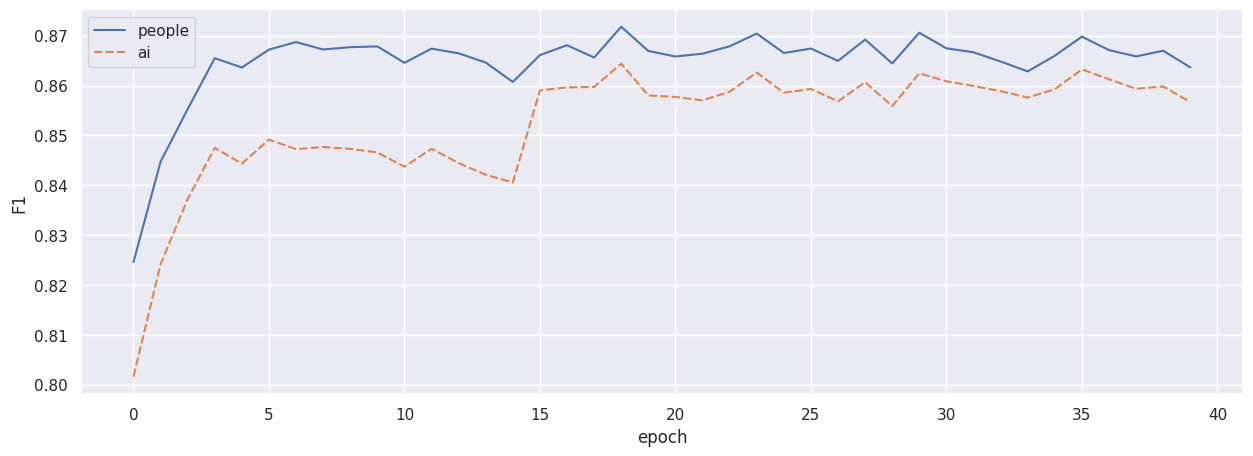

In [ ]:
NN_model = Train(model_NN, optimizer, criterion, scheduler, epochs, train_dataloader, eval_dataloader, device)

# Inference

Мы не успели сделать стеккинг и использовать предсказания катбуста и нейронки. Поэтому инференс мы провели только на предсказаниях затюненого берта.

In [ ]:
private_test = pd.read_csv('/content/private_test.csv')
print(private_test.shape)
private_test.head()

(2482, 2)


,context,answer
0,"**Вы:** Спасибо братан,тебя тоже!!!\n\n**Собес...",Краснодар - красивый город. Что тебе там больш...
1,**Вы:** Кем работаешь??\nЯ работаю косметолого...,"Но не знаю, как правильно ухаживать за ними. Я..."
2,**Вы:** Что читали из последнего?\n\n**Собесед...,Это жизнь
3,"**Вы:** Я мёдсистра, люблю путешествовать увле...","Живу в городе, но мечтаюо природе и своем доме"
4,**Вы:** А ты чем-то увлекаешься кроме спорта.\...,Начать никогда не поздно


In [ ]:
encodings = deep_pavlov_tokenizer(private_test['answer'].tolist(), truncation=True, padding=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings


    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings)

test_dataset = GroupsDataset(encodings, [0 for i in range(len(private_test))])

In [ ]:
test_pred = trainer.predict(test_dataset)

In [ ]:
labels = test_pred[0].argmax(-1)

In [ ]:
answer = pd.DataFrame({
                      'label': [label for label in labels]})
answer['label'] = answer['label'].apply(lambda x: 'people' if x == 0 else 'ai')

In [ ]:
answer['label'].value_counts()

people    1260
ai        1222
Name: label, dtype: int64

In [ ]:
answer.to_csv('rucode_submit.csv')